# Goal of this notebook: Examine effect of STR allele length on mutation frequency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

sns.set_context("poster")
%matplotlib inline

In [2]:
df_somatic_mutations = pd.read_csv("../../data/dummy_somatic_mutation_calls_filt.csv")
df_clinical = pd.read_csv("../../data/dummy_clinical.csv").assign(MSI = lambda x: pd.Categorical(x.MSI, categories=["MSS", "MSI"], ordered=True))

df_somatic_mutations.head()

,patient,tmp_id,period,ref,allele_a_healthy,allele_a_tumor,allele_b_healthy,allele_b_tumor,allele_a_diff,allele_b_diff,patient_len_diff
0,1,chr1_10008054,1,14,14,14,14,14,0,0,0
1,1,chr1_10014276,2,4,4,4,4,4,0,0,0
2,1,chr1_1004515,2,4,4,4,4,4,0,0,0
3,1,chr1_10054784,1,19,19,19,19,19,0,0,0
4,1,chr1_10059809,1,9,9,9,9,9,0,0,0


## First, make overview showing number of calls, number of (not) mutated calls per allele

In [3]:
df_allele_lengths_long = (
    df_somatic_mutations
        .rename(columns={'allele_a_diff': 'a', 'allele_b_diff': 'b'})
        .merge(
            df_clinical.loc[:, ["patient", "MSI"]], 
            on="patient", 
            how="left")
        .melt(
            id_vars=['patient', 'MSI', 'tmp_id', 'ref', 'period'],
            value_vars=['a', 'b'], 
            var_name='allele', 
            value_name='allele_diff')
        .drop('allele', axis=1)
)

df_allele_lengths_long.head()

,patient,MSI,tmp_id,ref,period,allele_diff
0,1,MSS,chr1_10008054,14,1,0
1,1,MSS,chr1_10014276,4,2,0
2,1,MSS,chr1_1004515,4,2,0
3,1,MSS,chr1_10054784,19,1,0
4,1,MSS,chr1_10059809,9,1,0


In [4]:
df_allele_lengths_long_summary = (
    df_allele_lengths_long
       .assign(instable_tmp = lambda x: x.allele_diff != 0)
       .groupby(["MSI", "tmp_id", "instable_tmp"])
       .size()
       .unstack(fill_value=0)
       .rename(columns={False: "n_not_mutated", True: "n_mutated"})
       .assign(
           total_calls = lambda x: x["n_not_mutated"] + x["n_mutated"],
           perc_variable = lambda x: x["n_mutated"] / x["total_calls"] * 100)
       .dropna()
       .reset_index()
)

df_allele_lengths_long_summary.head()

instable_tmp,MSI,tmp_id,n_not_mutated,n_mutated,total_calls,perc_variable
0,MSS,chr1_10008054,48,2,50,4.0
1,MSS,chr1_10014276,49,1,50,2.0
2,MSS,chr1_1004515,50,0,50,0.0
3,MSS,chr1_10054784,50,0,50,0.0
4,MSS,chr1_10059809,50,0,50,0.0


In [5]:
df_allele_lengths_long_summary = (
    df_allele_lengths_long_summary
       .merge(
           df_somatic_mutations[['tmp_id', 'period', 'ref']].drop_duplicates(),
           on='tmp_id', 
           how='left')
)

df_allele_lengths_long_summary.head()

,MSI,tmp_id,n_not_mutated,n_mutated,total_calls,perc_variable,period,ref
0,MSS,chr1_10008054,48,2,50,4.0,1,14
1,MSS,chr1_10014276,49,1,50,2.0,2,4
2,MSS,chr1_1004515,50,0,50,0.0,2,4
3,MSS,chr1_10054784,50,0,50,0.0,1,19
4,MSS,chr1_10059809,50,0,50,0.0,1,9


## For every combination of period, reference length calculate the percentage of loci that are mutated

In [6]:
df_mutations_agg = {'MSI': [], 'period': [], 'ref': [], 'n_calls': [], 'avg_perc_var': []}
for name, group in (df_allele_lengths_long_summary
     .groupby(["MSI", "period", "ref"], as_index=False)):
    df_mutations_agg['MSI'].append(name[0])
    df_mutations_agg['period'].append(name[1])
    df_mutations_agg['ref'].append(name[2])
    df_mutations_agg['n_calls'].append(np.sum(group.total_calls))

    df_mutations_agg['avg_perc_var'].append(np.average(group.perc_variable, weights=group.total_calls))
    
df_mutations_agg = pd.DataFrame(df_mutations_agg).assign(region_length = lambda x: x.period * x.ref)
df_mutations_agg

,MSI,period,ref,n_calls,avg_perc_var,region_length
0,MSS,1,9,2400,1.250000,9
1,MSS,1,10,1150,0.695652,10
2,MSS,1,11,800,1.000000,11
3,MSS,1,12,950,1.789474,12
4,MSS,1,13,1150,1.739130,13
...,...,...,...,...,...,...
131,MSI,5,11,50,6.000000,55
132,MSI,6,3,500,5.000000,18
133,MSI,6,4,250,6.800000,24
134,MSI,6,5,100,4.000000,30


## Plots of percentage mutated loci as a function of STR allele length

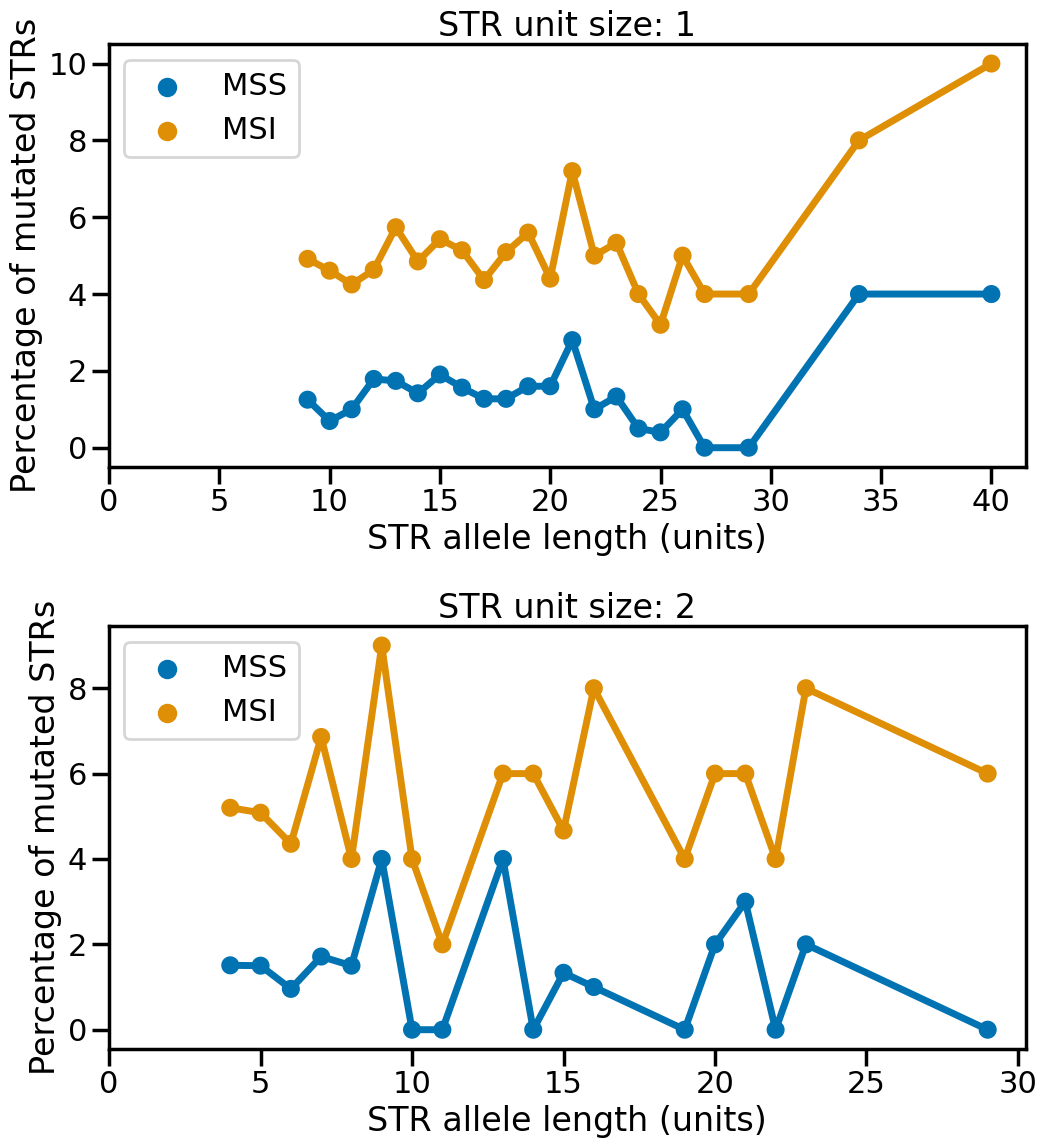

In [7]:
nrow, ncol = 2, 1
fig, axes = plt.subplots(nrow, ncol, 
                         figsize=(11, 12), 
#                          sharex=True, 
#                          sharey=True
                        )

min_n_calls = 2  # two alleles per patients so min_n_patients = min_n_calls / 2

for period in range(1, 3):
    ax = axes[period - 1]
    cur_data = df_mutations_agg.query(f"period == {period} and n_calls >= {min_n_calls}")
        
    sns.scatterplot(
        data = cur_data,
        x="ref",
        y="avg_perc_var",
        hue="MSI",
        palette="colorblind",
        ax = ax,
        s=200
    )
    ax.legend(title="")
    
    sns.lineplot(
        data = cur_data,
        x="ref",
        y="avg_perc_var",
        hue="MSI",
        palette="colorblind",
        legend=False,
        ax=ax,
        linewidth=5
    )

    ax.set(
        xlim=(0, None),
        title=f"STR unit size: {period}", 
        xlabel="STR allele length (units)",
        ylabel="Percentage of mutated STRs"
    )
    ax.xaxis.get_major_locator().set_params(integer=True)

fig.tight_layout()


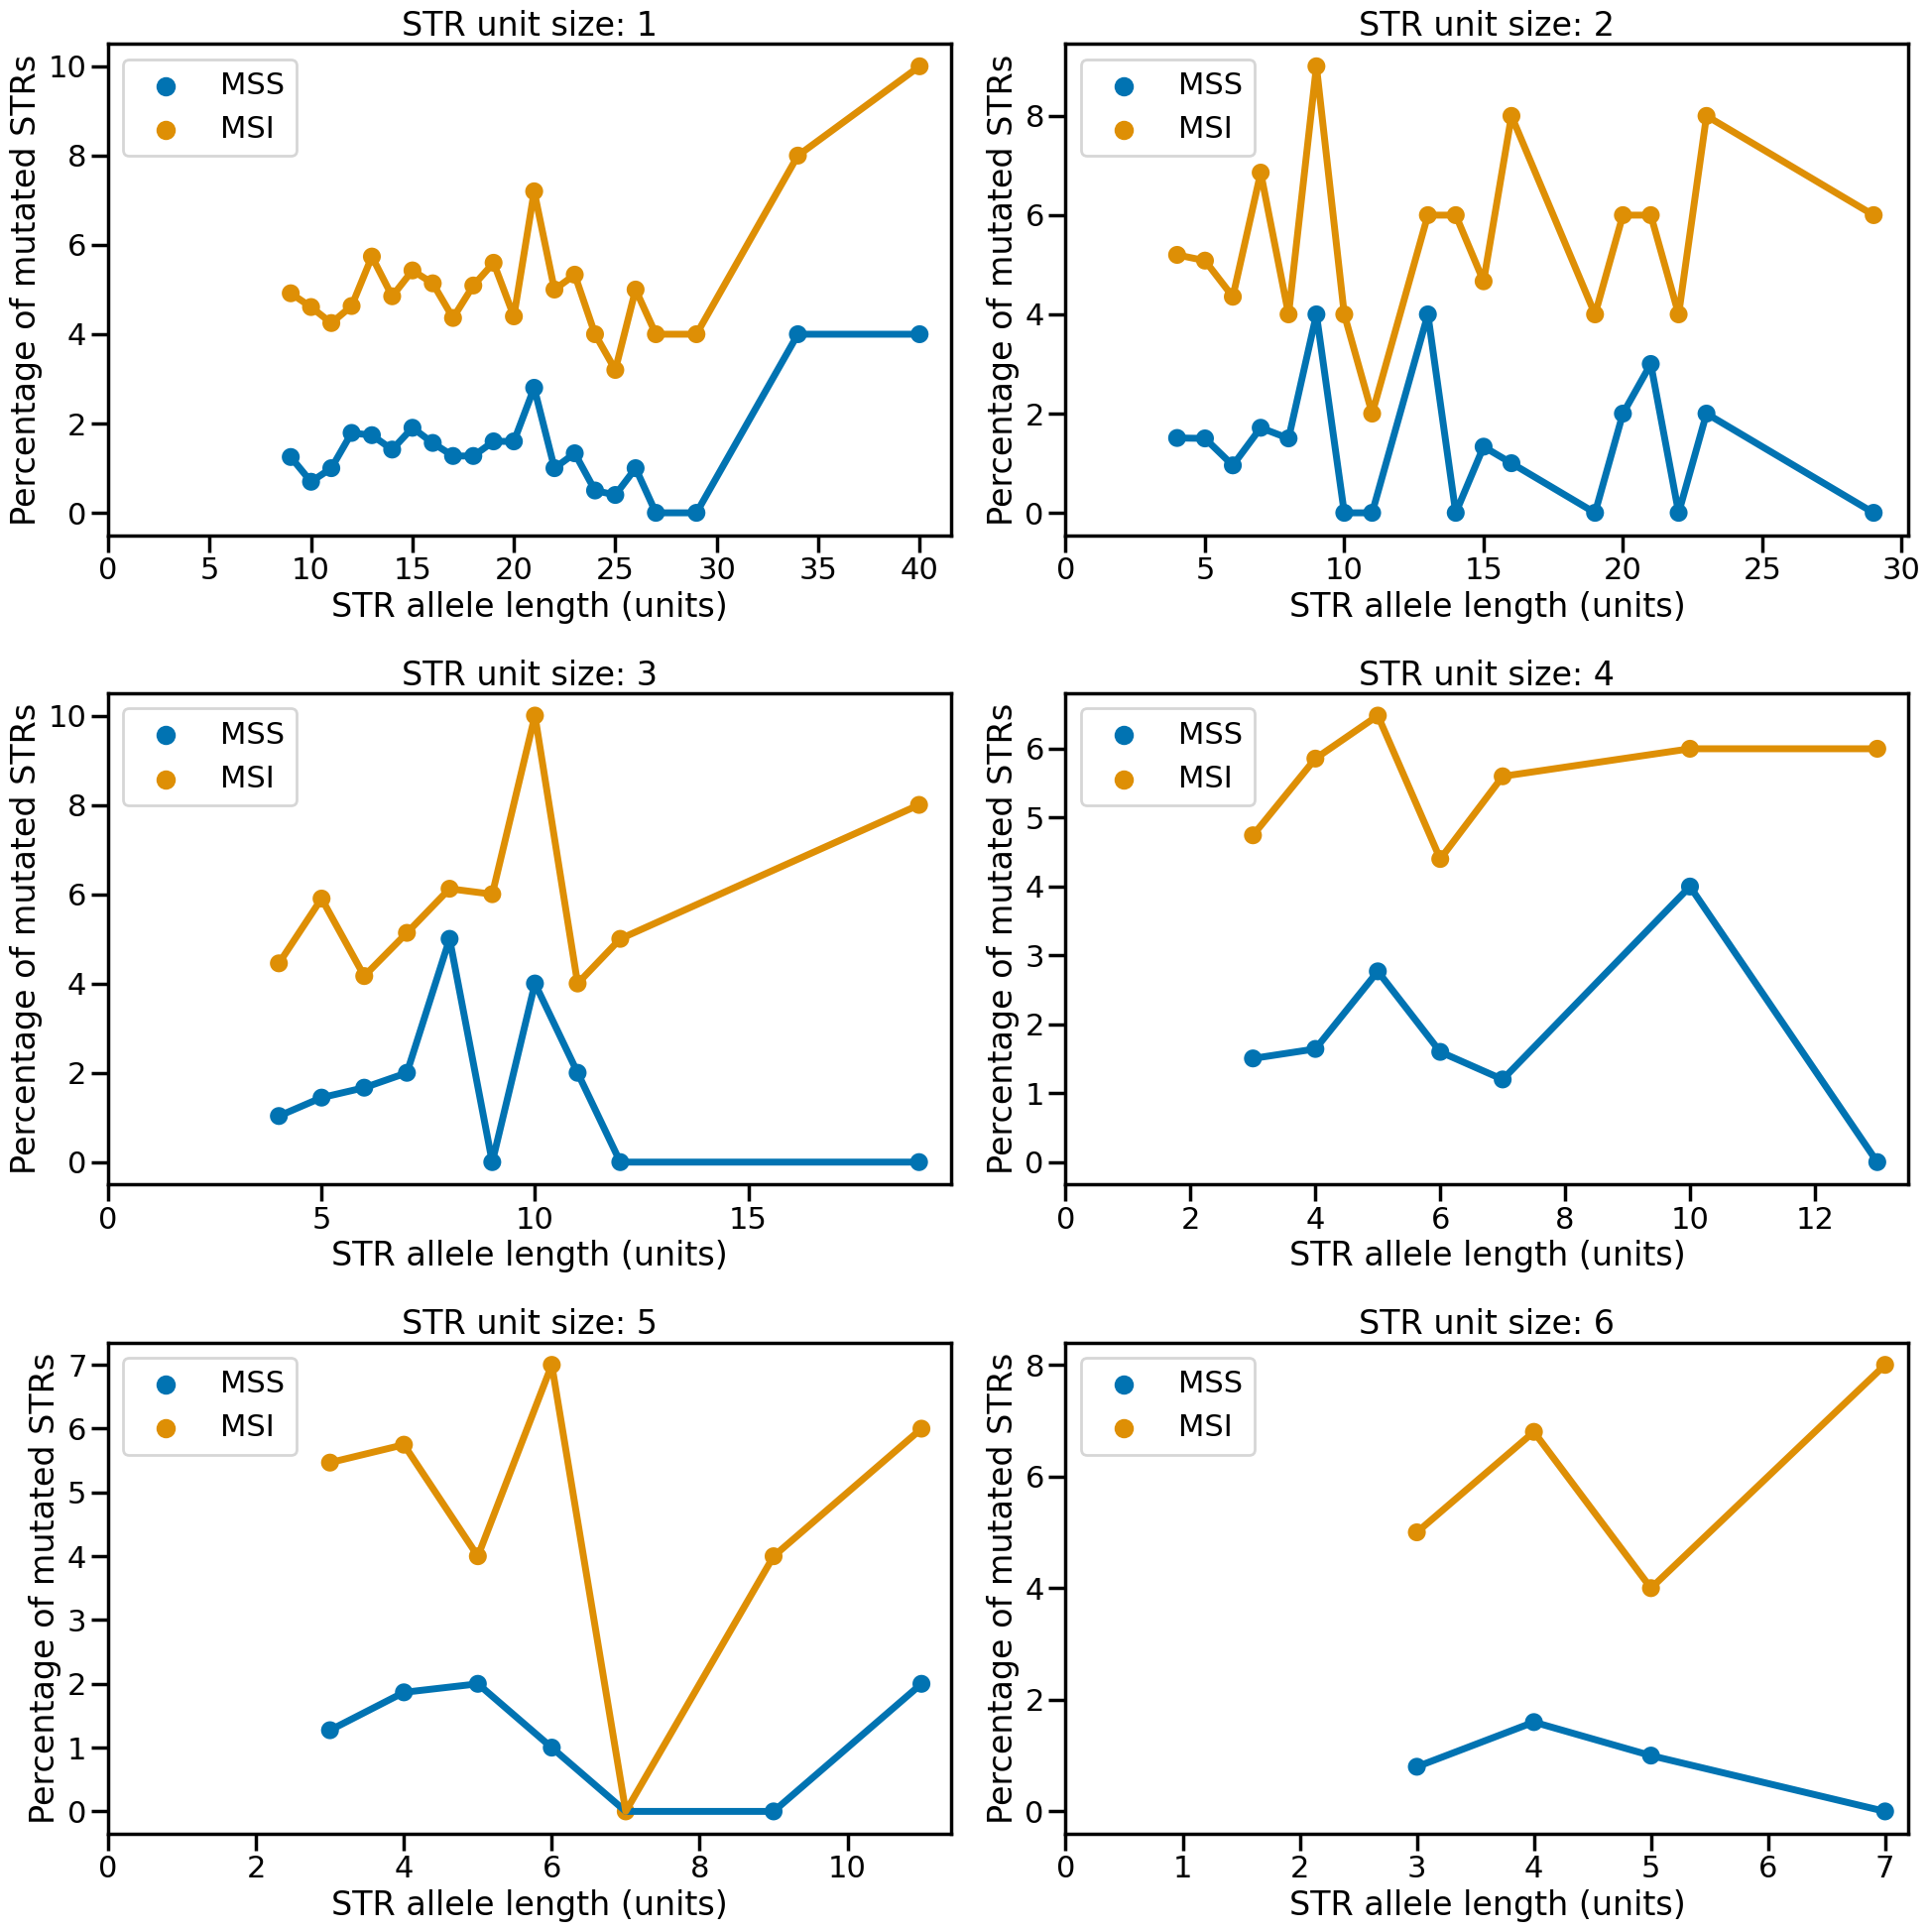

In [9]:
nrow, ncol = 3, 2
fig, axes = plt.subplots(nrow, ncol, 
                         figsize=(20, 20), 
#                          sharex=True, 
#                          sharey=True
                        )

for ax, period in zip(axes.ravel(), range(1, 7)):    
    df_cur_panel = df_mutations_agg.query(f"period == {period} and n_calls >= {min_n_calls}")
        
    sns.scatterplot(
        data = df_cur_panel,
        x="ref",
        y="avg_perc_var",
        hue="MSI",
        palette="colorblind",
        ax = ax,
        s=200
    )
    
    ax.legend(title="")
    
    sns.lineplot(
        data = df_cur_panel,
        x="ref",
        y="avg_perc_var",
        hue="MSI",
        palette="colorblind",
        legend=False,
        ax=ax,
        linewidth=5
    )

    ax.set(
        xlim=(0, None),
        title=f"STR unit size: {period}", 
        xlabel="STR allele length (units)",
        ylabel="Percentage of mutated STRs"
    )
    ax.xaxis.get_major_locator().set_params(integer=True)

fig.tight_layout()
